# Cost Benefit Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from sklearn.neighbors import KernelDensity

%matplotlib inline

## 1. When should we spray?

In [2]:
# Read in train and spray data
train = pd.read_csv('../assets/train_2.csv')
spray = pd.read_csv('../assets/spray_2.csv')

# Create day, week, month, year from data for spray and train dataset
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = (train['Date'].dt.strftime('%Y')).astype(int)
train['Month'] = (train['Date'].dt.month.astype(int))
train['Week'] = (train['Date'].dt.strftime('%W')).astype(int)
train['Day'] = (train['Date'].dt.day.astype(int))

spray['Date'] = pd.to_datetime(spray['Date'])
spray['Year'] = (spray['Date'].dt.strftime('%Y')).astype(int)
spray['Month'] = (spray['Date'].dt.month.astype(int))
spray['Week'] = (spray['Date'].dt.strftime('%W')).astype(int)
spray['Day'] = (spray['Date'].dt.day.astype(int))

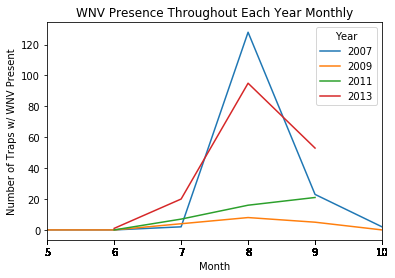

In [3]:
#The peaking between month's 7 and 9 is clearly seen, but much more prevalent in 2007 & 2013.
ax = train.groupby(by=['Year','Month'])['WnvPresent'].sum().unstack(level=0).plot(xticks=train['Month'], 
                                                                                        title='WNV Presence Throughout Each Year Monthly')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Traps w/ WNV Present');
plt.savefig('../assets/monthly_wnv.png')



From the chart above, we notice a trend where WNV presence peak between August and September but it's much more obvious in 2007 and 2013. Since we only have spray data for 2011 and 2013, and there were only 2 sprays in 2011, we will put our focus on sprays in 2013. 

In [4]:
# To remove spray location which is outside Chicago
spray = spray[(spray['Longitude']>=-88) & (spray['Latitude']<=42.3)]
spray.head()

,Date,Time,Latitude,Longitude,Year,Month,Week,Day
95,2011-09-07,0 days 07:52:52.000000000,41.981433,-87.787777,2011,9,36,7
96,2011-09-07,0 days 07:53:02.000000000,41.980998,-87.787778,2011,9,36,7
97,2011-09-07,0 days 07:53:12.000000000,41.980560,-87.787762,2011,9,36,7
98,2011-09-07,0 days 07:53:22.000000000,41.980198,-87.787758,2011,9,36,7
99,2011-09-07,0 days 07:53:32.000000000,41.979752,-87.787765,2011,9,36,7


In [5]:
# We only want to look at data in 2013
train_2013 = train[train['Year']==2013]

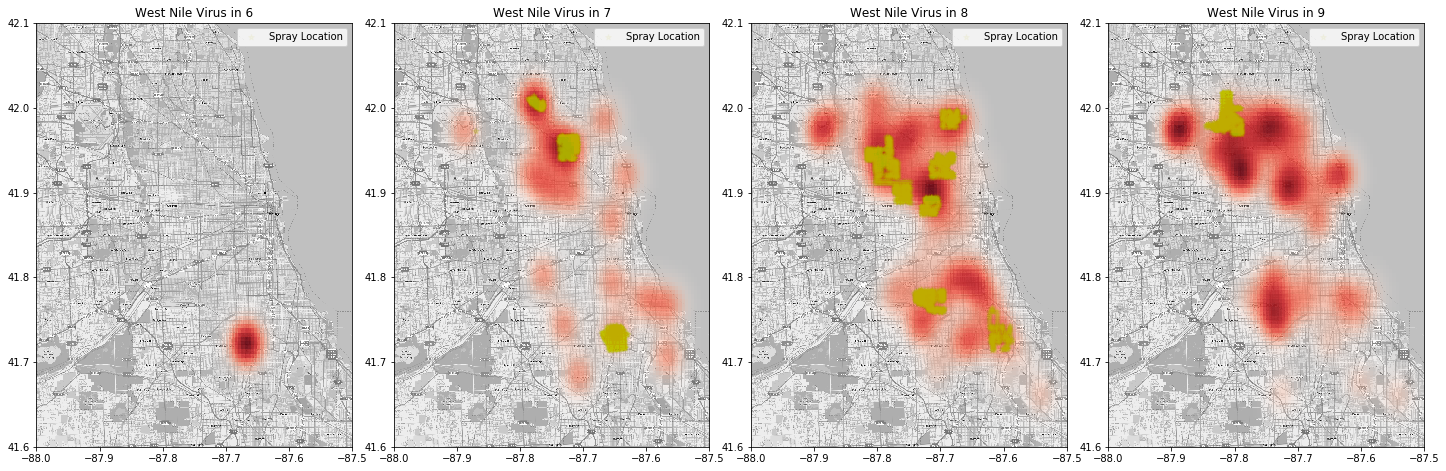

In [6]:
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

# Map trap and west nile heatmap 
fig, ax = plt.subplots(figsize = (20,9),nrows = 1, ncols = 4, sharey = False)
fig.tight_layout()
for idx, month in enumerate(train_2013['Month'].unique()):
    # Show map in desired lat, long range 
    axis = ax[idx]
    axis.imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
               aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])
    
    # Scatter plot for trap locations 
    traps = train_2013[['Longitude', 'Latitude']].drop_duplicates().values
    
    # Plot a density map of West Nile Virus sighting
    alphas = plt.cm.Reds
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = train_2013[['Longitude','Latitude']][(train_2013['WnvPresent'] == 1) & (train_2013['Month'] == month)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axis.imshow(zv,
               origin = 'lower',
              cmap = alphas,
              extent = (-88, -87.5, 41.6, 42.1),
              aspect = mapdata.shape[0]*1.0/mapdata.shape[1])
    # Scatter plot for spray locations (removing outliers far away from the rest of the traps)
    spray_loc = spray[['Longitude', 'Latitude','Month']].drop_duplicates()
    current = spray_loc[spray_loc['Month']==month]
    axis.scatter(current['Longitude'], current['Latitude'], marker = '*', color = 'y', label = "Spray Location", alpha=0.05)
    # Labels
    axis.set_title(f"West Nile Virus in {month}")
    axis.legend();
    plt.savefig('../assets/effectiveness_of_spray.png')
    

By plotting the heatmap on prevalence of WNV in 2013 by month, we can see that prevalence of the WNV indeed peaks between July and September. This suggests that if we start spraying in early-July (before the expected spike in mid July), we may be able to reduce the prevalence of WNV in subsequent months.

Next, we will look at where we can target the spraying to increase the effectiveness of sprays.

## 2. Where should we spray?

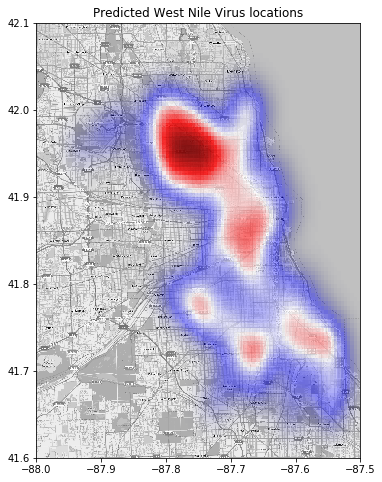

In [7]:
# plot possible outbreak areas
# Plot west nile predictions geographically 
# Initialize map 
pred = pd.read_csv('../assets/sub_pred.csv')
plt.figure(figsize = (12,8))
ax = plt.gca()
ax.imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
           aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])
# Plot a density map of our West Nile Virus predictions
alphas = plt.cm.seismic
alphas._init()
alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
virus_loc = pred[['Longitude','Latitude']]
kern = KernelDensity(bandwidth = 0.02)
kern.fit(virus_loc.values)
xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(), yv.ravel()]).T
zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
ax.imshow(zv,
          origin = 'lower',
          cmap = alphas,
          extent = (-88, -87.5, 41.6, 42.1),
          aspect = mapdata.shape[0]*1.0/mapdata.shape[1])
plt.title("Predicted West Nile Virus locations")
plt.savefig('../assets/dangerzones.png')
plt.show()

This heatmap shows the predicted area where there will be WNV based on our model. We can hence target the sprays to these area to increase the effectiveness of the spray, and thereby reducing the prevalence of WNV.

## 3. Weighing the cost of inaccuracy

Since this is a classification problem, we would ideally want to work towards minimizing the number of false positive and false negative classifications. Especially when such misclassification would result in an increased probability of epidemic or unnecessarily spending money on spraying locations where there is low likelihood of WNV being detected. 

In our classification:

False Positive refers to the scenario where we predicted that the area has the WNV virus but it does not actually have the virus. This could result in an increase in spraying when it is not required, as well as creating fear and loss in productivity if anyone is quarantined. 

False Negative on the other hand refers to the scenario where we predicted that an area is free of WNV but in actual fact it's plagued with the WNV. This may potentially lead to an increased chance of human epidemic and eventually resulting in a huge negative economic impact downstream.

<img src="../assets/confusion_matrix.png">

## 4. Calculating the Cost VS Savings

From our model, roughly about 234 sq miles are predicted to be have WNV. To calculate the cost of spraying, we first assume that we will be spraying about 40% of Chicago and the cost of spraying per mile is ~11k, the estimated cost of spraying would be

$$ 0.4 * 234 sq miles * $11,000 = $1.03 million $$

We assume we managed to reduce the number of WNV from 117 to 44 from 2016 to 2016

We find that each infection case cost roughly $24k and we can calculate the savings we can get by reducing the number of WNV from 117 in 2013 to 44 in 2014.

$$ (117-44) * $24,000 = $1.75million $$ 

Overall, we can get a total of <font color=red>$720k</font> in savings by making the decision to spray.

## 5. Conclusion and Recommendations

Since the savings from spraying is greater then the cost of spraying, we would recommend to always spray in order to control the spread of WNV. We could also consider spraying slightly earlier, near early July before the expected peak of WNV to further reduce the spread of west nile virus.

In addition, we could consider larviciding in late June, which is the process of controlling mosquitoes when they are in the larvae or pupal form. This could further prevent the spread of WNV in subsequent months.



## 6. References


1. https://www.cdc.gov/westnile/statsmaps/cumMapsData.html
2. https://chicagoflaneur.com/2016/06/20/a-different-way-of-looking-at-density-in-chicago/
3. https://www.sporcle.com/games/No1LesbroinChi/populated_chicago_neighborhoods/results
4. https://www.sciencedaily.com/releases/2014/02/140210184713.htm
5. http://www.cidrap.umn.edu/news-perspective/2004/07/west-nile-magnifies-need-mosquito-control
